In [1]:
import numpy as np
import tensorflow as tf
import traci
import timeit
from generator import TrafficGenerator
from enum import Enum
import matplotlib.pyplot as plt
# import seaborn as sns

No Model yet <br>
Baseline: Simple periodic traffic light system

In [197]:
tf.__version__

'2.3.0'

In [ ]:
max_steps = None
num_cars = None
TrafficGen = TrafficGenerator(max_steps, num_cars)

In [198]:
# self._Model = Model
# self._Memory = Memory

class LightPhase(Enum):
    PHASE_NS_GREEN = 0
    PHASE_NSL_GREEN = 1
    PHASE_EW_GREEN = 2
    PHASE_EWL_GREEN = 3
    
class Simulation:
    def __init__(self, TrafficGen, sumo_cmd, max_steps, green_duration, yellow_duration):
        self._TrafficGen = TrafficGen
        # self._gamma = gamma
        self._step = 0
        self._sumo_cmd = sumo_cmd
        self._max_steps = max_steps
        self._green_duration = green_duration
        self._yellow_duration = yellow_duration
        # self._num_states = num_states
        # self._num_actions = num_actions
        self._reward_store = []
        self._cumulative_wait_store = []
        self._avg_queue_length_store = []
        self._training_epochs = training_epochs
    
    def run(self, ):
        start_time = timeit.default_timer()
        self._TrafficGen.generate_routefile(seed=0)
        traci.start(self._sumo_cmd)
        print("Simulating...") #:>
        
        
        self._sum_waiting_time = 0
        old_state = -1
        old_action = -1
        
        
        while self._step < self._max_steps:
            current_state = self._get_state()
            current_total_wait = self._collect_waiting_times()
            
            action = self._choose_action(state, baseline=True)
            
            #we only trigger a yellow light if we aren't doing the same action again
            if self._step != 0 and old_action != action:
                self._set_yellow_phase(old_action)
                self._simulate(self._yellow_duration)  
            
            self._set_green_phase(action)
            self.simulate(self._green_duration)
            
            old_state = current_state
            old_action = action
            old_total_wait = current_total_wait
        
        
        traci.close()
        simulation_time = round(timeit.default_timer() - start_time, 2)
        return simulation_time
            
            
    def _choose_action(self, state, baseline=True):
        #simple periodic action sequence
        if baseline:
            return (self.action + 1) % 4
    
    def _set_yellow_phase(self, old_action):
        yellow_phase_code = old_action * 2 +1
        traci.trafficlight.setPhase("TL", yellow_phase_code)
        
    def _set_green_phase(self, action):
        traci.trafficlight.setPhase("TL", LightPhase(action).name)
        
    def _simulate(self, steps_todo):
        steps_todo = min(steps_todo, self._max_steps - self._step)
        
        while steps_todo > 0:
            traci.simulationStep()
            self._step += 1
            steps_todo -= 1
#             queue_length = self._get_queue_length()
#             self._sum_queue_length += queue_length
#             self._sum_waiting_times += queue_length
            
            
#     def _get_queue_length(self):
#         halt_N = traci.edge.getLastStepHaltingNumber("N2TL")
#         halt_S = traci.edge.getLastStepHaltingNumber("S2TL")
#         halt_E = traci.edge.getLastStepHaltingNumber("E2TL")
#         halt_W = traci.edge.getLastStepHaltingNumber("W2TL")
#         queue_length = halt_N + halt_S + halt_E + halt_W
#         return queue_length

    def _collect_watiing_times(self):
        incoming_roads = "E2TL N2TL W2TL S2TL".split()
        car_list = traci.vehicle.getIDList()
        for car_id in car_list:
            if traci.vehicle.getRoadID(car_id) in incoming_roads:
                self._waiting_times[car_id] = traci.vehicle.getAccumulatedWaitingTime(car_id)
            elif car_id in self._waiting_times:
                del self._waiting_times[car_id]
        return sum(self._waiting_times.values())
    
    def _get_state(self):
        """
        Retrieve the state of the intersection from sumo, in the form of cell occupancy
        """
        state = np.zeros(self._num_states)
        car_list = traci.vehicle.getIDList()

        for car_id in car_list:
            lane_pos = traci.vehicle.getLanePosition(car_id)
            lane_id = traci.vehicle.getLaneID(car_id)
            lane_pos = 750 - lane_pos  # inversion of lane pos, so if the car is close to the traffic light -> lane_pos = 0 --- 750 = max len of a road

            # distance in meters from the traffic light -> mapping into cells
            if lane_pos < 7:
                lane_cell = 0
            elif lane_pos < 14:
                lane_cell = 1
            elif lane_pos < 21:
                lane_cell = 2
            elif lane_pos < 28:
                lane_cell = 3
            elif lane_pos < 40:
                lane_cell = 4
            elif lane_pos < 60:
                lane_cell = 5
            elif lane_pos < 100:
                lane_cell = 6
            elif lane_pos < 160:
                lane_cell = 7
            elif lane_pos < 400:
                lane_cell = 8
            elif lane_pos <= 750:
                lane_cell = 9

            # finding the lane where the car is located 
            # x2TL_3 are the "turn left only" lanes
            if lane_id == "W2TL_0" or lane_id == "W2TL_1" or lane_id == "W2TL_2":
                lane_group = 0
            elif lane_id == "W2TL_3":
                lane_group = 1
            elif lane_id == "N2TL_0" or lane_id == "N2TL_1" or lane_id == "N2TL_2":
                lane_group = 2
            elif lane_id == "N2TL_3":
                lane_group = 3
            elif lane_id == "E2TL_0" or lane_id == "E2TL_1" or lane_id == "E2TL_2":
                lane_group = 4
            elif lane_id == "E2TL_3":
                lane_group = 5
            elif lane_id == "S2TL_0" or lane_id == "S2TL_1" or lane_id == "S2TL_2":
                lane_group = 6
            elif lane_id == "S2TL_3":
                lane_group = 7
            else:
                lane_group = -1

            if lane_group >= 1 and lane_group <= 7:
                car_position = int(str(lane_group) + str(lane_cell))  # composition of the two postion ID to create a number in interval 0-79
                valid_car = True
            elif lane_group == 0:
                car_position = lane_cell
                valid_car = True
            else:
                valid_car = False  # flag for not detecting cars crossing the intersection or driving away from it

            if valid_car:
                state[car_position] = 1  # write the position of the car car_id in the state array in the form of "cell occupied"

        return state
            

In [37]:
incoming_roads = "E2TL N2TL W2TL S2TL".split()
d = dict(zip(incoming_roads, [1, 2, 3, 4]))

In [40]:
sum(d.values())

10

In [30]:
class testy:
    def __init__(self):
        print("initialized")
    
    def print_lp(self):
        print(LightPhase(2).name)

In [45]:
class LightPhase(Enum):
    PHASE_NS_GREEN = 0
    PHASE_NSL_GREEN = 2
    PHASE_EW_GREEN = 4
    PHASE_EWL_GREEN = 6

In [19]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [199]:
class Model:
    def __init__(self, num_layers, width, input_dim, output_dim, learning_rate):
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.model_a = self._build_model(num_layers, width)
        self.model_b = self._build_model(num_layers, width)
    
    def _build_model(self, num_layers, width):
        inputs = Input((self.input_dim,))
        
        X = Dense(width, activation="relu")(inputs)
        for i in range(num_layers-1):
            X = Dense(width, activation='relu')(X)
        outputs = Dense(self.output_dim, activation='linear')(X)
        
        opt = Adam(lr=self.learning_rate)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss = MeanSquaredError(), optimizer=opt)
        return model
    
    def _predict(self, model_a, state):
        if model_a:
            return self.model_a.predict(state)
        else:
            return self.model_b.predict(state)
    
    def save_model(self, path):
        self.model_a.save(os.path.join(path, 'trained_model_a.h5'))
        self.model_b.save(os.path.join(path, 'trained_model_b.h5'))

In [208]:
from tensorflow.keras.models import load_model
import os

In [209]:
class TestModel(Model):
    def __init__(self, load_path):
        self.model_a, self.model_b = self._load_models(load_path)
        
    def _load_models(self, path):
        return load_model(os.path.join(path, 'trained_model_a.h5')), \
                   load_model(os.path.join(path, 'trained_model_a.h5'))

In [213]:
model = TestModel("models")
model._predict(True, np.random.randn(1, 80))

array([[127.38421 , -43.02566 , -75.406715, -86.43907 ]], dtype=float32)

In [ ]:
model.

In [58]:
input_dim = 20
output_dim = 4
num_layers = 4
width = 40
learning_rate = 0.01

inputs = Input((input_dim,))

X = Dense(width, activation="relu")(inputs)
for i in range(num_layers-1):
    X = Dense(width, activation='relu')(X)
outputs = Dense(output_dim, activation='linear')(X)

opt = Adam(lr=learning_rate)

m = keras.Model(inputs=inputs, outputs=outputs)
m.compile(loss = MeanSquaredError(), optimizer=opt)


In [78]:
inputs = np.random.randn(20,)

In [79]:
inputs.shape

(20,)

In [80]:
n = inputs.shape
inputs = inputs.reshape((1, len(inputs)))
# inputs.shape


In [114]:

m.predict(inputs).shape

(1, 4)

In [119]:
from random import sample

In [142]:
buffer = [(np.random.randn(1, 20), 2, 3), (np.random.randn(1, 20), 3, 4)]
buffer = np.random.randn(5, 20)
# buffer = [1]

In [136]:
[[i[0], i[1]] for i in sample(buffer, 2)][0]

[array([[ 0.04249936, -1.43150159,  0.69195723,  1.24015439, -0.1121719 ,
          1.35408057, -0.6813249 , -0.74183885, -0.75453361, -0.1576713 ,
         -1.43466983,  0.94678468,  0.18796667,  1.66567042,  1.65473167,
         -0.83127557,  0.54455564, -2.69732184,  0.98155567, -0.41933276]]),
 2]

In [111]:
buffer = []
np.random.choice(buffer, len(buffer), replace=False)

array([], dtype=float64)

In [167]:
q_s = m.predict(buffer)

In [190]:
argmaxes = np.argmax(q_s, axis=1).reshape(1, -1)
argmaxes

array([[1, 1, 1, 0, 1]], dtype=int64)

In [168]:
q_s.shape

(5, 4)

In [179]:
q_s[argmaxes]

array([[ 0.02377159,  0.3006861 , -0.02153228,  0.10008422],
       [ 0.02377159,  0.3006861 , -0.02153228,  0.10008422],
       [ 0.02377159,  0.3006861 , -0.02153228,  0.10008422],
       [ 0.15308717,  0.8150898 , -0.29949862,  0.5507115 ],
       [ 0.02377159,  0.3006861 , -0.02153228,  0.10008422]],
      dtype=float32)

In [195]:
for i in range(0):
    print(i)

In [194]:
np.take_along_axis(q_s, argmaxes, axis=1)

array([[ 0.8150898 ,  0.8150898 ,  0.8150898 ,  0.15308717,  0.8150898 ],
       [ 0.3006861 ,  0.3006861 ,  0.3006861 ,  0.02377159,  0.3006861 ],
       [ 0.26197928,  0.26197928,  0.26197928, -0.05748827,  0.26197928],
       [-0.06870117, -0.06870117, -0.06870117,  0.02547749, -0.06870117],
       [ 0.26727164,  0.26727164,  0.26727164,  0.01313314,  0.26727164]],
      dtype=float32)

In [215]:
dict(zip(list(range(4)), [0]*4))

{0: 0, 1: 0, 2: 0, 3: 0}

In [217]:
from tensorflow.keras import backend as K

In [220]:
K.set_value(model.model_a.optimizer.learning_rate, 0.001)

In [17]:
data_store = []

0: Polynomial

In [18]:
f = open("models/only-batch-lltrain-new-reward-polynomial-alpha-4summedn/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

1: Adaptive

In [19]:
f = open("models/only-batch-longtrain-new-reward-adaptive-alpha/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

2: Single DQN

In [20]:
f = open("models/only-batch-single-dqn-alpha001/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

3: Double alpha = 0.001 

In [21]:
f = open("models/only-batch-lltrain-alpha001/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

4: Double alpha = 0.01 

In [22]:
f = open("models/only-batch-longtrain-alpha01/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

5: Gamma = 0.95

In [23]:
f = open("models/only-batch-lltrain-new-reward-new-gamma-polynomial-alpha-4summedn/plot_reward_data.txt", 'r')
data = f.read()
f.close()
data = data.split('\n')
data.remove('')
data = [float(i) for i in data]
data_store.append(data)

In [96]:
import matplotlib
font = {'size'   : 20}

matplotlib.rc('font', **font)

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\user\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


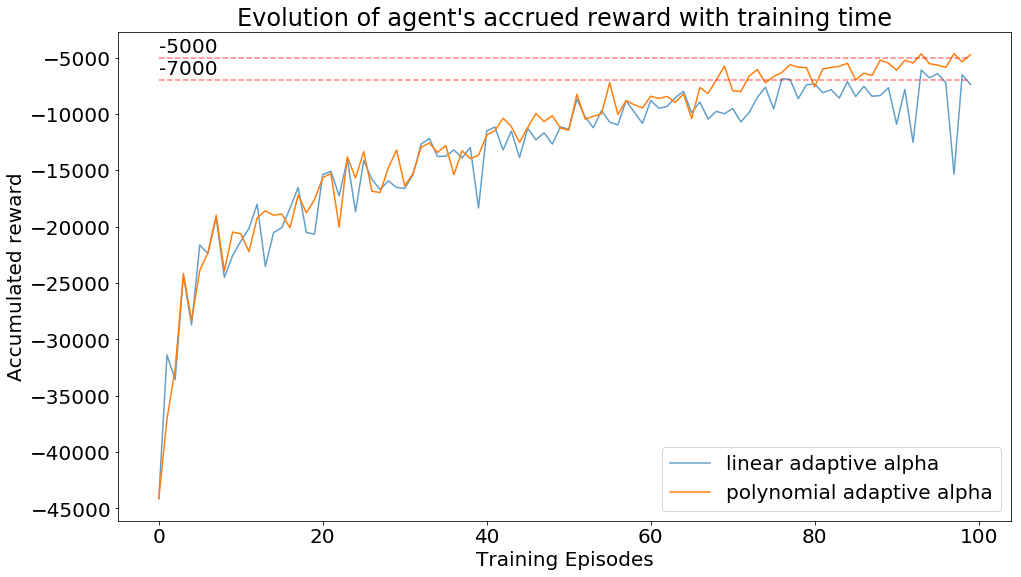

In [97]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(data_store[1])), data_store[1], label="linear adaptive alpha", alpha=0.7)
plt.plot(range(len(data_store[2])), data_store[0], label="polynomial adaptive alpha", alpha=1)
plt.plot(range(100), [-5000]*100, '--r', alpha=0.5)
plt.plot(range(100), [-7000]*100, '--r', alpha=0.5)
plt.text(0, -4500, "-5000")
plt.text(0, -6500, "-7000")
plt.xlabel("Training Episodes")
plt.ylabel("Accumulated reward")
plt.title("Evolution of agent's accrued reward with training time")
plt.legend()

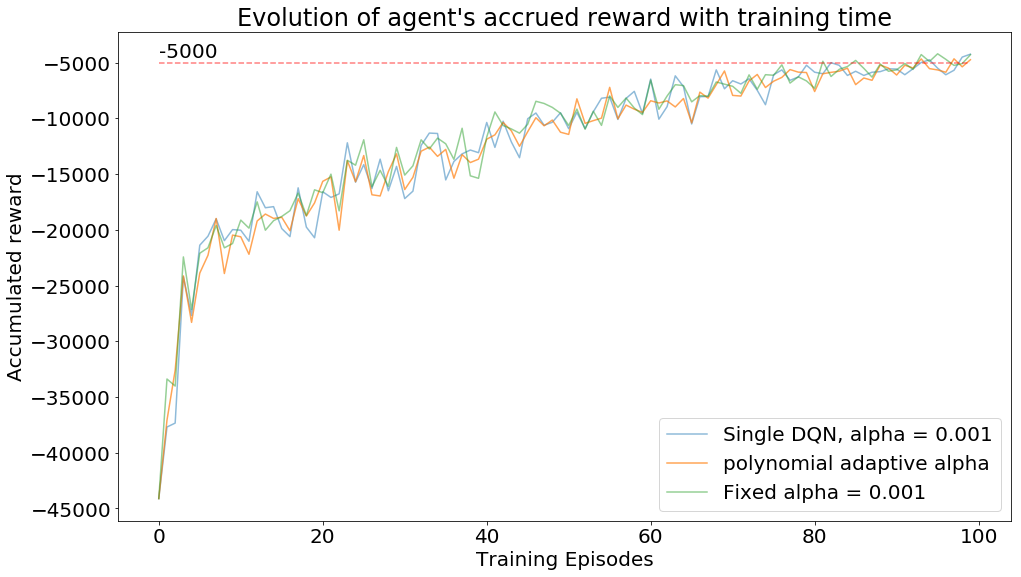

In [98]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(data_store[3])), data_store[2], label="Single DQN, alpha = 0.001", alpha=0.5)
plt.plot(range(len(data_store[2])), data_store[0], label="polynomial adaptive alpha", alpha=0.7)
plt.plot(range(len(data_store[2])), data_store[3], label="Fixed alpha = 0.001", alpha=0.5)

plt.plot(range(100), [-5000]*100, '--r', alpha=0.5)
# plt.plot(range(100), [-3000]*100, '--r', alpha=0.5)
plt.yticks(np.arange(-45000, 0, 5000))
# plt.text(0, -2500, "-3000")
plt.text(0, -4500, "-5000")
plt.xlabel("Training Episodes")
plt.ylabel("Accumulated reward")
plt.title("Evolution of agent's accrued reward with training time")
plt.legend()

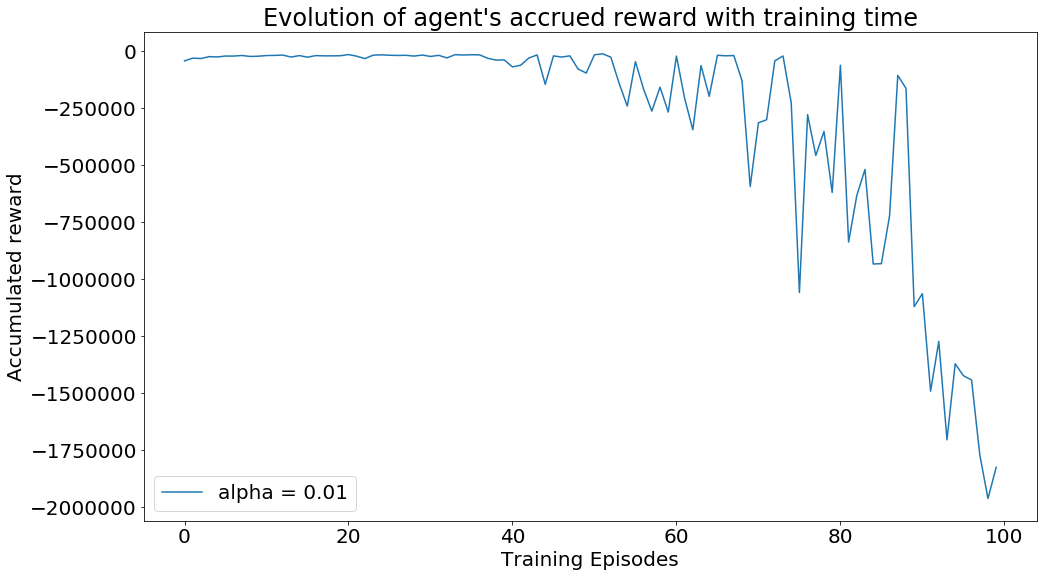

In [99]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(data_store[4])), data_store[4], label="alpha = 0.01")
plt.xlabel("Training Episodes")
plt.ylabel("Accumulated reward")
plt.title("Evolution of agent's accrued reward with training time")
plt.legend()

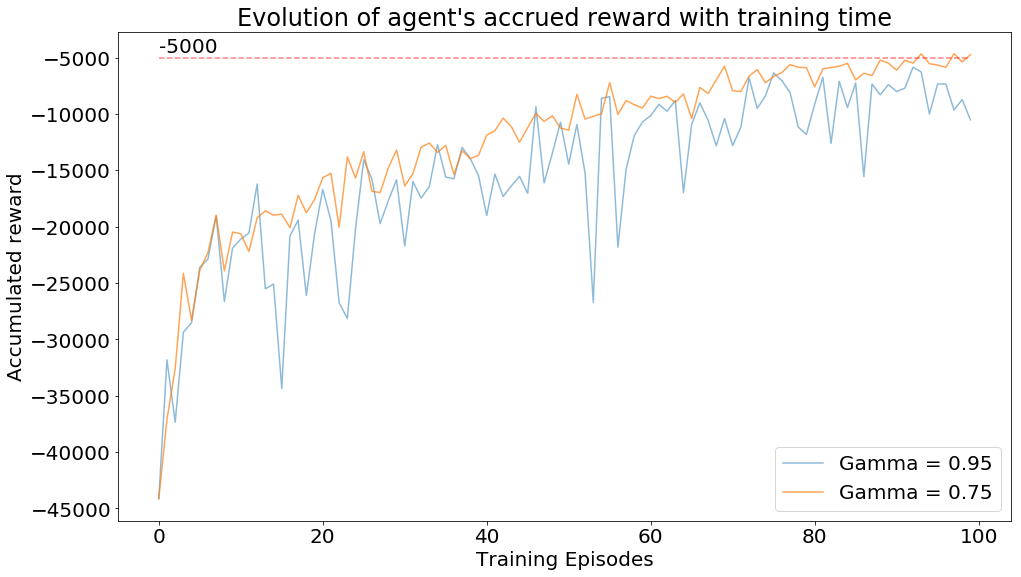

In [100]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(data_store[3])), data_store[5], label="Gamma = 0.95", alpha=0.5)
plt.plot(range(len(data_store[2])), data_store[0], label="Gamma = 0.75", alpha=0.7)

plt.plot(range(100), [-5000]*100, '--r', alpha=0.5)
# plt.plot(range(100), [-3000]*100, '--r', alpha=0.5)
plt.yticks(np.arange(-45000, 0, 5000))
# plt.text(0, -2500, "-3000")
plt.text(0, -4500, "-5000")
plt.xlabel("Training Episodes")
plt.ylabel("Accumulated reward")
plt.title("Evolution of agent's accrued reward with training time")
plt.legend()

0: Polynomial

In [84]:
wait_times = {"low_density": [0], "medium_density": [0], "high_density": [0]}
queue_length = {"low_density": [0], "medium_density": [0], "high_density": [0]}

In [85]:
for i in range(1, 7):
    f = open("data/low_density/" +str(i) +"total_wait_times.txt", 'r')
    data = f.read()
    f.close()
    data = data.split('\n')
    data.remove('')
    data = [float(i) for i in data]
    wait_times["low_density"].append(data)
    
    f = open("data/medium_density/" +str(i) +"total_wait_times.txt", 'r')
    data = f.read()
    f.close()
    data = data.split('\n')
    data.remove('')
    data = [float(i) for i in data]
    wait_times["medium_density"].append(data)
    
    f = open("data/low_density/" +str(i) +"avg_queue_length.txt", 'r')
    data = f.read()
    f.close()
    data = data.split('\n')
    data.remove('')
    data = [float(i) for i in data]
    queue_length["low_density"].append(data)

    f = open("data/medium_density/" +str(i) +"avg_queue_length.txt", 'r')
    data = f.read()
    f.close()
    data = data.split('\n')
    data.remove('')
    data = [float(i) for i in data]
    queue_length["medium_density"].append(data)

In [86]:
for i in [1, 2, 3, 4, 5, 6]:
    
    if (i == 5):
        wait_times["high_density"].append(5)
        queue_length["high_density"].append(5)
    else:
        f = open("data/high_density/" +str(i) +"total_wait_times.txt", 'r')
        data = f.read()
        f.close()
        data = data.split('\n')
        data.remove('')
        data = [float(i) for i in data]
        wait_times["high_density"].append(data)

        f = open("data/high_density/" +str(i) +"avg_queue_length.txt", 'r')
        data = f.read()
        f.close()
        data = data.split('\n')
        data.remove('')
        data = [float(i) for i in data]
        queue_length["high_density"].append(data)

In [87]:
import seaborn as sns

In [88]:
len(wait_times["low_density"][1])

473

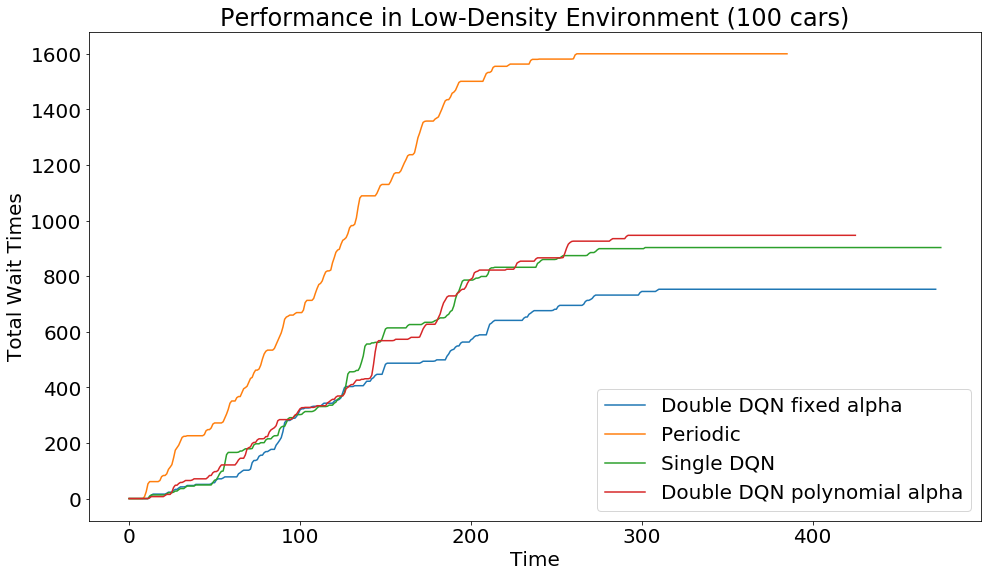

In [106]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(wait_times["low_density"][1])), wait_times["low_density"][1], label="Double DQN fixed alpha")
plt.plot(range(len(wait_times["low_density"][6])), wait_times["low_density"][6], label = "Periodic")
plt.plot(range(len(wait_times["low_density"][4])), wait_times["low_density"][4], label="Single DQN")
plt.plot(range(len(wait_times["low_density"][2])), wait_times["low_density"][2], label="Double DQN polynomial alpha")
plt.xlabel("Time")
plt.ylabel("Total Wait Times")
plt.title("Performance in Low-Density Environment (100 cars)")
plt.legend()

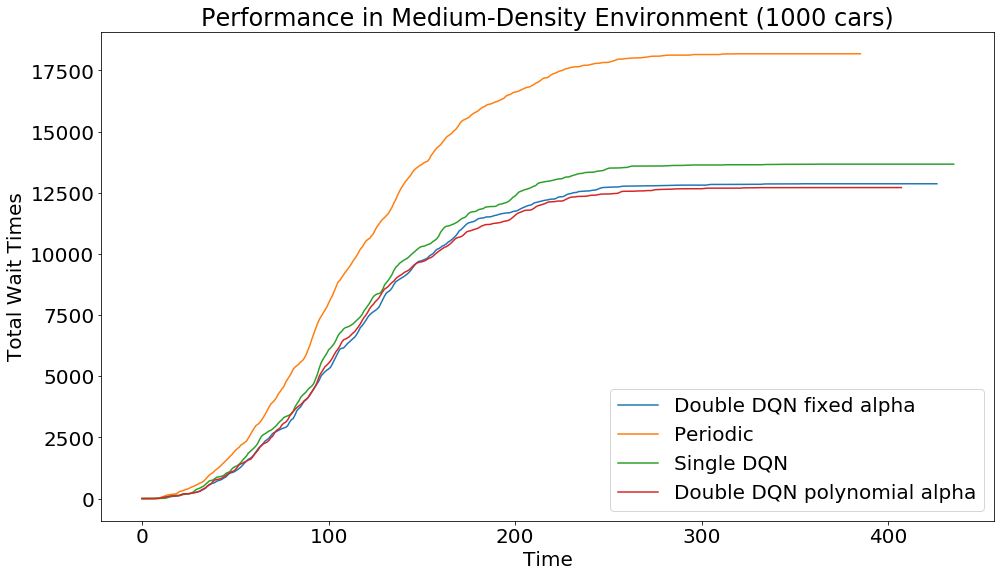

In [105]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(wait_times["medium_density"][1])), wait_times["medium_density"][1], label="Double DQN fixed alpha")
plt.plot(range(len(wait_times["medium_density"][6])), wait_times["medium_density"][6], label = "Periodic")
plt.plot(range(len(wait_times["medium_density"][4])), wait_times["medium_density"][4], label="Single DQN")
plt.plot(range(len(wait_times["medium_density"][2])), wait_times["medium_density"][2], label="Double DQN polynomial alpha")
plt.xlabel("Time")
plt.ylabel("Total Wait Times")
plt.title("Performance in Medium-Density Environment (1000 cars)")
plt.legend()

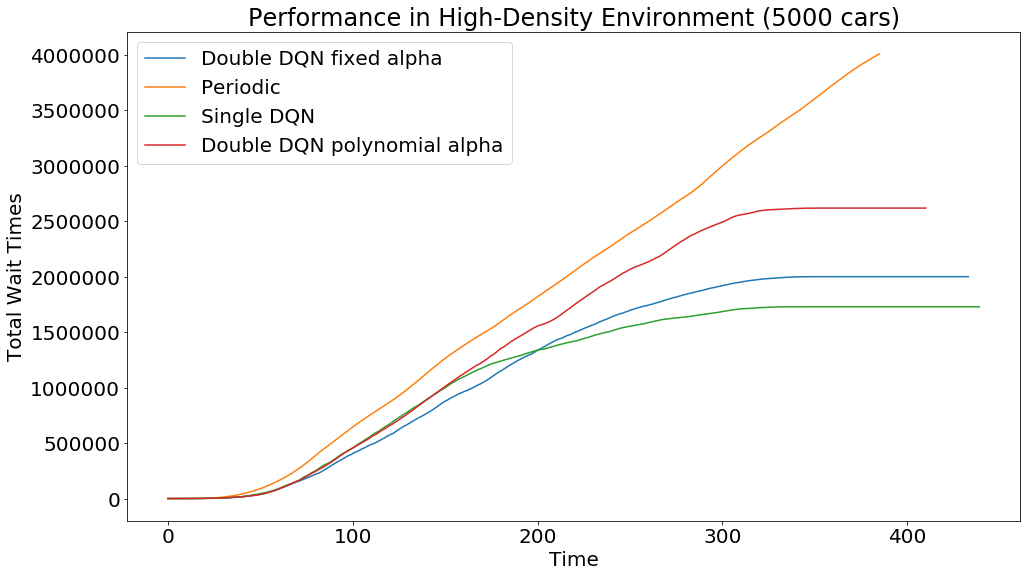

In [104]:
plt.figure(figsize=[16, 9])
plt.plot(range(len(wait_times["high_density"][1])), wait_times["high_density"][1], label="Double DQN fixed alpha")
plt.plot(range(len(wait_times["high_density"][6])), wait_times["high_density"][6], label = "Periodic")
plt.plot(range(len(wait_times["high_density"][4])), wait_times["high_density"][4], label="Single DQN")
plt.plot(range(len(wait_times["high_density"][2])), wait_times["high_density"][2], label="Double DQN polynomial alpha")
plt.xlabel("Time")
plt.ylabel("Total Wait Times")
plt.title("Performance in High-Density Environment (5000 cars)")
plt.legend()